# Data Re-Uploading for Circular Data Set, 11 Dimensional Qudit

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np


from scipy.sparse.linalg import expm
from scipy.sparse import coo_matrix, csc_matrix, diags, identity


import jax.numpy as jnp
from jax import grad, vmap, jit
from jax import random

import jax

import scipy

from tqdm import tqdm

from sklearn.utils import shuffle

import qutip as q

from tqdm import tqdm

from bloch_3d_plot import plot_bloch



from sklearn.model_selection import train_test_split



We again first define the spin matrices and the functions that act on a state.

In [2]:
l = 5 # spin length

# let's put together spin matrices
dim_qudit = 2*l+1
qudit_range = np.arange(l, -(l+1),-1)

Id  =  scipy.sparse.csc_matrix(identity(dim_qudit))
Lx  =  scipy.sparse.csc_matrix(1/2*diags([np.sqrt([(l-m+1)*(l+m) for m in qudit_range[:-1]]), np.sqrt([(l+m+1)*(l-m) for m in qudit_range[1:]]) ], [-1, 1]))
Lz  =  scipy.sparse.csc_matrix(diags([qudit_range], [0]))
Lz2 = Lz.multiply(Lz)
Lx2 = Lx.multiply(Lx)

Lx = Lx.toarray()
Lz = Lz.toarray()
Lz2 = Lz2.toarray()


Lx = jnp.array(Lx)
Lz = jnp.array(Lz)
Lz2 = jnp.array(Lz2)

In [3]:
def Rx(psi, theta, conj=False):
    if conj:
        Ux = jax.scipy.linalg.expm(1j*theta*Lx)
    else:
        Ux = jax.scipy.linalg.expm(-1j*theta*Lx)
    psi = jnp.dot(Ux,psi)
    return psi

def Rz(psi, theta, conj=False):
    if conj:
        Uz = jax.scipy.linalg.expm(1j*theta*Lz)
    else:
        Uz = jax.scipy.linalg.expm(-1j*theta*Lz)
    psi = jnp.dot(Uz,psi)
    return psi

def Rz2(psi, theta, conj=False):
    if conj:
        Uz2 = jax.scipy.linalg.expm(1j*theta*Lz2)
    else:
        Uz2 = jax.scipy.linalg.expm(-1j*theta*Lz2)
    psi = jnp.dot(Uz2,psi)
    return psi

def Initialization(psi :np.array, x1: float, x2: float, conj=False)-> np.array:
    psi = Rz(psi, x1)
    return Rx(psi, x2)



In [4]:
state_labels = [[0], [-1]]

def cost_circ(params, x, y):

    
    loss = 1-circ(params, x, y)**2
    return loss 


def circ(params, x, y):

    psi = 1j*jnp.zeros(int(l*2+1))
    #This is necessary since jnp arrays are immutable
    psi = jax.ops.index_add(psi, 0, 1+1j*0)
    
    label = 1j*jnp.zeros(int(l*2+1))
    #This is necessary since jnp arrays are immutable
    y = y
    #print(y)
    label = jax.ops.index_add(label, y, 1+1j*0)
    for i in range(len(params)):
    
        psi = Initialization(psi, x[0], x[1])
    
        psi = Rz(psi, params[i][0])
        psi = Rx(psi, params[i][1])
        psi = Rz(psi, params[i][2])
    #print(psi)
    
    return jnp.abs(jnp.dot(psi, label))


def test(params, x, state_labels=state_labels):

    fidelity_values = []
    dm_labels = state_labels
    predicted = []

    
    fidelities = jnp.array([circ(params, x, dm) for dm in dm_labels])
    best_fidel = jnp.argmax(fidelities)
    #print(fidelities, best_fidel)
    

    return best_fidel

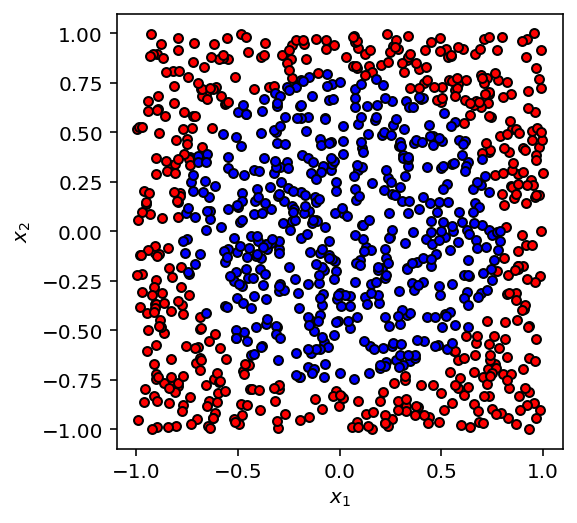

In [5]:
def accuracy_score(y_true, y_pred):

    score = y_true == y_pred
    return score.sum() / len(y_true)

# Set a random seed
# Make a dataset of points inside and outside of a circle
def circle(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):

    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x) < radius:
            y = -1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)




def plot_data(x, y, fig=None, ax=None, title=None):

    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == -1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_title(title)


Xdata, ydata = circle(1000)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(Xdata, ydata, fig=fig, ax=ax)

def iterate_minibatches(inputs, targets, batch_size):

    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

We then need the gradient of the cost function.

In [6]:
@jit
def vmap_cost(params, X_batched, y_batched):
    return vmap(cost_circ,  in_axes=(None, 0, 0))(params, X_batched, y_batched).sum()/len(X_batched)

@jit
def vmap_cost_ind(params, X_batched, y_batched, beta=0.3):
    return vmap(cost_circ,  in_axes=(None, 0, 0, None, None))(params, X_batched, y_batched, beta, True)

@jit
def vmap_test(params, X_batched, state_labels):
    return vmap(test,  in_axes=(None, 0, None))(params, X_batched, state_labels)


cost_circ_grad = grad(vmap_cost, argnums=0)

In [7]:
state_labels_flat = np.array(state_labels).flatten()

Now we have everything we need and can start learning. We first create the dataset and choose random parameters to start.

In [8]:
x_data, y_data = circle(1000)

batch_size = 100

num_layers = 5

num_params = 3

x_data, y_data = shuffle(x_data, y_data)


train_x, test_x, train_y, test_y = train_test_split(x_data, y_data)

used_labels_arr = np.array(state_labels)[:, 0]

In [11]:
num_layers_list = [1, 2, 3, 4, 5, 6 ,7, 8, 9]
np.random.seed(2)




batch_size = 50

num_params = 3


for num_layer in num_layers_list:

    for j in tqdm(range(1)):
        x_data, y_data = circle(1000)
        x_data, y_data = shuffle(x_data, y_data)
        train_x, test_x, train_y, test_y = train_test_split(x_data, y_data)
        
        #print("--------------------------------------")
        #print(f"Starting Learning with {num_layer} layer(s)!")

        params = np.random.uniform(size=(num_layer, num_params))*np.pi/2


        beta=0

        losses = []
        train_acc = []
        param_list = []

        epochs = 40

        learning_rate = 0.05
        opt = AdamOptimizer(learning_rate)

        for i in range(epochs):
            #print("--------------------------------------")
            #print(f"Starting Epoch {i+1}, learning rate: {learning_rate:.2f}")

            x_train, y_train = shuffle(train_x, train_y)
            for X_Batch, Y_Batch in iterate_minibatches(x_train, y_train, batch_size):
                #print(X_Batch.shape, Y_Batch.shape)
                params = opt.step(vmap_cost, params, grad_fn=cost_circ_grad, X_batched=X_Batch, y_batched=Y_Batch)
            param_list.append(params)
            pred_test = vmap_test(params, test_x, state_labels_flat)
            pred_test = np.array(pred_test)
            for n, prediction in enumerate(pred_test):
                pred_test[n] = used_labels_arr[prediction]
            acc = accuracy_score(test_y, pred_test)
            loss = vmap_cost(params, train_x, train_y)


            losses.append(loss)
            train_acc.append(acc)
            #print(f"Epoch {i+1}, Loss: {loss:.3f}, Accuracy: {acc:.3f}")
            #print(params)

        #np.save(f"Add11DimLossCalc/params_{num_layer}-layers-{j}.npy", param_list)
        np.save(f"Add11DimLossCalc/loss_{num_layer}-layers-{j+21}.npy", losses)
        #np.save(f"Add11DimLossCalc/acc_{num_layer}-layers-{j}.npy", train_acc)





100%|██████████| 1/1 [00:53<00:00, 53.06s/it]
